# Clustarization

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering, DBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score

from sklearn.decomposition import PCA

from clust_functions import plot, get_size, silhouette_plot

import warnings
warnings.filterwarnings("ignore")

RAND = 10

In [2]:
data_bin = pd.read_csv('data_bin.csv')
data_bin.head()

,name,total_crashes,total_runs,year,nov22,dec22,jan23,feb23,mar23,apr23,...,category_Radiation,category_Roughness,category_StartStopSaveLoad,category_Subregions,category_Substances,category_Turbulence,category_UserFunction,category_VerificationTests,category_Vizu,category_tutorial
0,06_Plate2D_45_turb,25,2398,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,08_NACA0012_a8_M03,25,2319,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0_diam_0_particles,22,1959,2015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0_diam_0_particles2,14,1534,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0_surface_supergroup,3,1272,2018,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
X = data_bin.drop('name', axis=1)

In [4]:
X.shape

(1700, 48)

<div class="alert alert-block alert-info">
Итого получилось 1700 объектов и 48 признаков.
</div>

# Снижение размерности признакового пространства

Снижение размерности для задачи кластеризации поможет:
- визуализировать данные, что приблизит к пониманию структуры кластеров 
- повысить эффективность обучения за счёт уменьшения признаков (уйти от проклятия размерности)

Алгоритмы понижения размерности можно разделить на 2 основные группы: 
- Линейные алгоритмы (PCA и др.)
- Нелинейные алгоритмы, которые в свою очередь делятся на подходы, которые:

    - сохраняют глобальную структуру данных (nonlinear MDS)
    - сохраняют локальные расстояния между точками (t-SNE и др.)
    - сохраняют глобальную и локальную структуру (UMAP)

Проверим возможности базового алгоритма - PCA, затем обратимся к более сложным подходам.

###  PCA (Principal Component Analysis)

In [5]:
# стандартизируем данные, что важно для PCA
X_scaled = StandardScaler().fit_transform(X)

In [6]:
# задём размерность пространства для отображения
pca = PCA(n_components=3, random_state=RAND)
X_pca = pca.fit_transform(X_scaled)

In [7]:
print(f"собственные значения:\n {pca.explained_variance_}\n")
print(f"собственные векторы:\n {pca.components_}")

собственные значения:
 [5.80892446 3.46025573 2.38424002]

собственные векторы:
 [[-0.00298128 -0.06873111  0.09217279  0.30044549  0.3166891   0.35989038
   0.26935046  0.25787175  0.36728962  0.36784254  0.33865636  0.25018507
   0.1458685   0.12318251  0.10079454  0.00167779 -0.09178023 -0.04006122
  -0.07714226 -0.00249703  0.02656721 -0.00241518  0.01629368  0.03121426
   0.00944306  0.10429689  0.00189741 -0.00917877 -0.02026735 -0.01677888
  -0.00949774  0.01442617  0.03065578 -0.00467281 -0.01395333 -0.00698151
  -0.00339828 -0.00559105 -0.00911754  0.00961442 -0.02043702  0.00405502
   0.00079262 -0.03864389 -0.00721968 -0.0076626  -0.00487724  0.00837151]
 [ 0.21153771  0.47799494 -0.48862728  0.01608037  0.0794042   0.09923324
   0.19704451  0.06387764  0.05840293  0.04202729  0.09006226 -0.05879403
  -0.12331122 -0.16367942 -0.11873581 -0.06930468  0.49147669 -0.07852962
   0.03395036 -0.12130333 -0.06939004 -0.00623596 -0.04360802 -0.12904625
  -0.06084393 -0.03701246  0.0

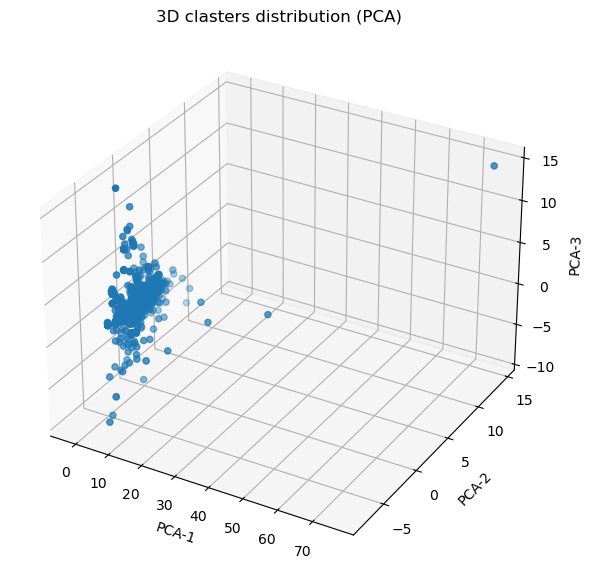

In [8]:
ax = plt.figure(figsize=(10,7)).gca(projection='3d')
ax.scatter(
    xs=X_pca[:, 0], 
    ys=X_pca[:, 1], 
    zs=X_pca[:, 2], 
)
ax.set_title('3D clasters distribution (PCA)')
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_zlabel('PCA-3')
plt.show()

In [9]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))

1 component: 12.09% of initial variance
2 component: 7.2% of initial variance
3 component: 4.96% of initial variance



<div class="alert alert-block alert-info">
Метод неприемлем для дальнейшего анализа. Визуально все объекты слеплены в одну группу, информативность трёх главных компонент низкая. Значительная потеря информации является результатом того, что PCA только отбирает признаки, а не создаёт новые метапризнаки для уменьшения размерности.
    
</div>

###  UMAP (Uniform Manifold Approximation and Projection)

UMAP схож с t-SNE и обладает рядом преимуществ:
- у UMAP нет ограничений на размерность исходного пространства признаков
- он намного быстрее и более вычислительно эффективен, чем t-SNE (ленейная сложность vs. квадратичная сложность)
- лучше справляется с задачей переноса глобальной структуры данных в новое, уменьшенное пространство.

In [10]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
from umap.umap_ import UMAP

In [12]:
%time
um = UMAP(n_components=3, random_state=RAND)
X_umap = um.fit_transform(X)

Wall time: 0 ns


In [13]:
X_embedding_3 = pd.DataFrame(X_umap)

# сохраняем файл в трёхмерном признаковом пространстве
X_embedding_3.to_pickle(r'../X_embedding_3.pkl') 

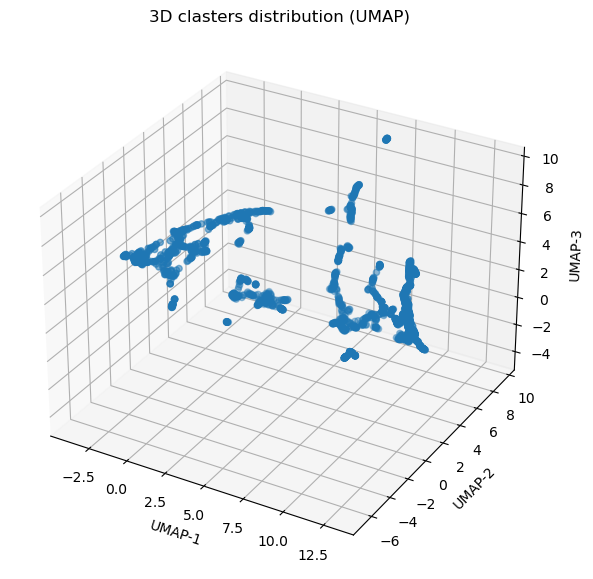

In [14]:
ax = plt.figure(figsize=(10,7)).gca(projection='3d')
ax.scatter(
    xs=X_umap[:, 0], 
    ys=X_umap[:, 1], 
    zs=X_umap[:, 2], 
)
ax.set_title('3D clasters distribution (UMAP)')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

<div class="alert alert-block alert-info">

Отображение на пространство трёх метапризнаков даёт отделимые и сгруппированные кластеры. Визуально можно выделить 3-6 крупных класстеров. 
    
</div>

###  Снижение размерности для кластеризации 

Выше размер пространства энмеддингов был выбран = 3 для визуализации. Для дальнейшей кластеризации, возможно, больше признаков даст лучший результат. Поэтому сгенерируем эмбеддинги в 16-ти мерном (1/3 от общего числа признаков) и 12-ти мерном (1/4 от общего числа признаков) пространствах.

In [15]:
um_16 = UMAP(n_components=16, random_state=RAND)
X_16 = um_16.fit_transform(X)
X_embedding_16 = pd.DataFrame(X_16)

In [16]:
um_12 = UMAP(n_components=12, random_state=RAND)
X_12 = um_12.fit_transform(X)
X_embedding_12 = pd.DataFrame(X_12)

# Кластеризация

Алгоритм кластеризации выбирем на основе области применения:
- Выпуклая структура (что бывает не очень часто) - K-means, он и быстрее и проще, но чувствителен к выбору начальной точки, поэтому можно попробовать K-means++
- Сложная нелинейная структура (аля спиралька) со сложными связями - Spectral Clustering, но вычислительно дорогой
- Кластеры в виде плотностей - DBSCAN / OPTICS, но нужно подбирать грамотно параметры
- Кластеры различной плотности и формы, присутствует шум - HDBSCAN
- Сложная структура, нечеткие границы, данные как смесь нормальных распределений - Gaussian Mixture Models

Визуально кластеры достаточно упакованные, поэтому за опорные алгоритмы возьмём DBSCAN и OPTICS. Также рассмотрим Spectral Clustering.

На данном этапе посмотрим как отрабатывают baseline алгоритмов. Оценивать качество будем визуально и по описанию кластеров (размер, топ признаки). В качестве метрики возьмём силуэтный коэффициент.

# DBSCAN

Огромным достоинством использования DBSCAN для данной задачи является то, что алгоритму на вход не требуется подавать количество кластеров. На самом деле, это и есть основной вопрос к модели. Пока нет понимания сколько кластеров образуется из данного набора тестов, также нет конкретного запроса на заданное число кластеров. Поэтому будем смотреть на ответ модели.

Гиперпараметры DBSCAN: 
- размер окрестности – eps;
- минимальное количество соседей в кластере – minpt (Эмпирика + чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим значение следует взять)

Параметры dbscan sklearn: 
- eps=0.5 (The maximum distance between two samples)
- min_samples=5 (The number of samples (or total weight) in a neighborhood)
- metric='euclidean'
- metric_params=None
- algorithm='auto'
- leaf_size=30
- p=None (If None, then p=2 (equivalent to the Euclidean distance))
- n_jobs=None

In [17]:
# DBCKAN baseline
dbscan = DBSCAN()

### DBSCAN baseline

Применим DBSCAN baseline на эмбеддингах 3, 12 и 16 мерной размерности. Проверим, нет ли уменьшения информативности из-за излишнего уменьшения размерности: оценим количество кластеров и силуэтный коэффициент для них.

In [18]:
dbscan.fit(X_umap)

db_labels_3 = dbscan.labels_ + 1 # метки кластеров
n_clust_3 = len(set(db_labels_3)) # количество кластеров
n_clust_3

28

In [19]:
dbscan.fit(X_12)

db_labels_12 = dbscan.labels_ + 1 # метки кластеров
n_clust_12 = len(set(db_labels_12)) # количество кластеров
n_clust_12

29

In [20]:
dbscan.fit(X_16)
db_labels_16 = dbscan.labels_ + 1
n_clust_16 = len(set(db_labels_16))
n_clust_16

31

<div class="alert alert-block alert-info">

Количество кластеров для эмбеддингов 3, 12 и 16 мерной размерности получилось близким (количественной разницы не наблюдается) . Посмотрим на силуэтный коэффициент. 
    
</div>

#### Силуэтный коэффиент 

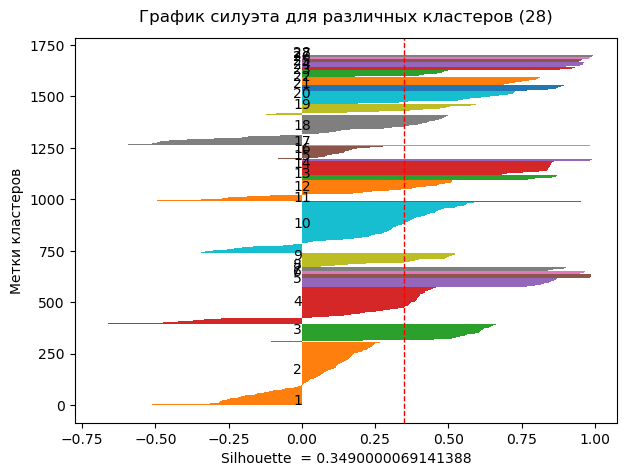

In [21]:
silhouette_plot(X_embedding_3, db_labels_3)

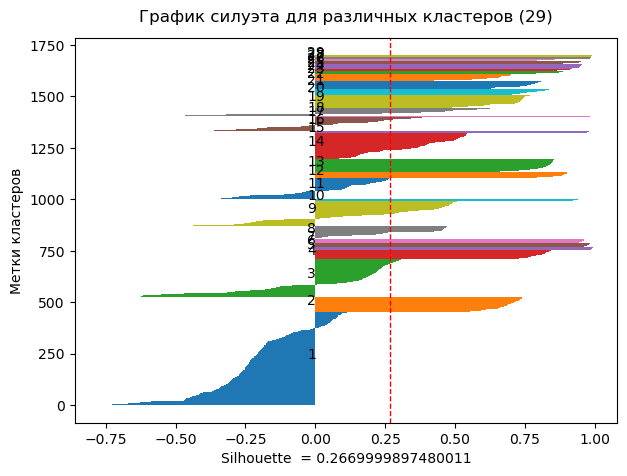

In [22]:
silhouette_plot(X_embedding_12, db_labels_12)

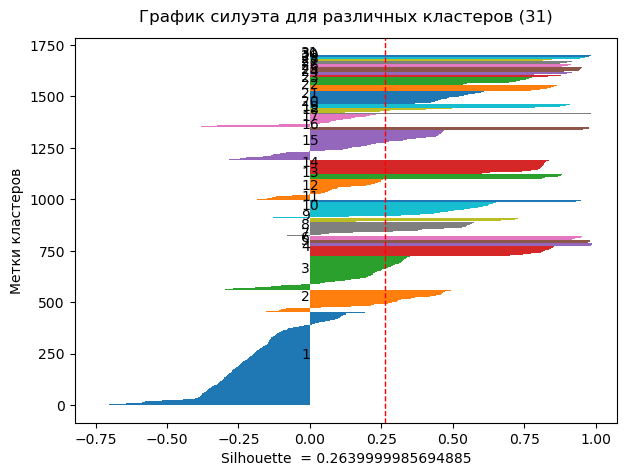

In [23]:
silhouette_plot(X_embedding_16, db_labels_16)

<div class="alert alert-block alert-info">

Средний силуэтный коэффициент для эмбеддингов 12-ти и 16-ти мерной размерности не отличается.
    
В случае 3-х мерных эмбеддингов результат лучше. 

**Остановимся на 3-х мерном представлении пространства признаков**
    
</div>

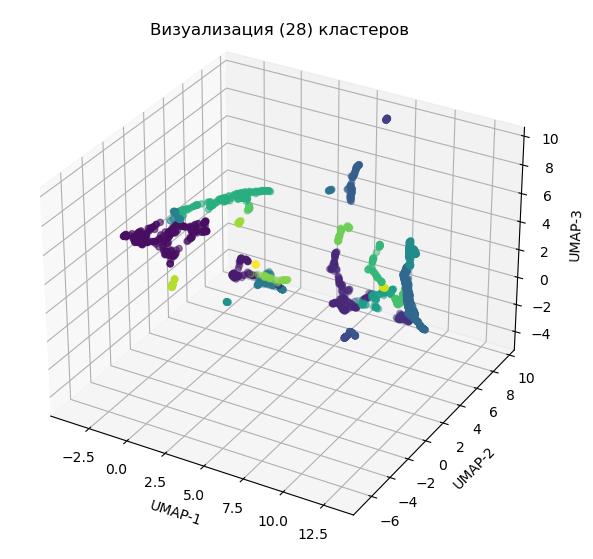

In [24]:
# Визуализация DBSCAN baseline
plot(X_embedding_3, db_labels_3)


<div class="alert alert-block alert-info">

Результаты кластеризации при помощи DBSCAN baseline сложно интерпретировать по визуализации. Вроде заметны отделимые группы, но они перемешаны.

</div>

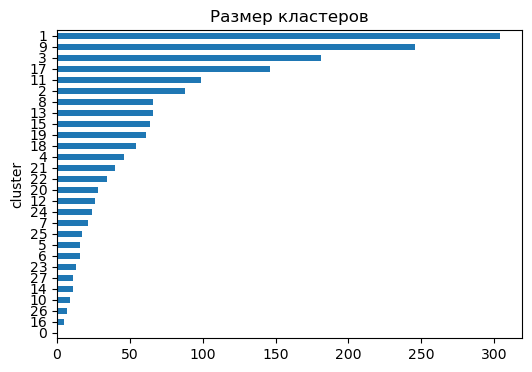

In [25]:
# Отображение размеров кластеров
get_size(X_embedding_3, db_labels_3)

<div class="alert alert-block alert-info">

Кластеры непропорциональны по размерам. 
В 1-ом кластере содержится 1/5 всех элементов (около 300). \
В тоже время половина кластеров содержат 50 и меньше элементов.

</div>

In [26]:
# Топ признаки для каждого кластера

X_clust=X.assign(cluster=db_labels_3) # добавляем метку кластера в датасет
cluster_size = X_clust.groupby('cluster').count().iloc[:, 0] # размер кластеров

data_sum = X_clust.groupby('cluster').sum()
data_sum_norm = data_sum.T / cluster_size

data_sum_norm

cluster,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
total_crashes,207.0,104.062500,60.840909,31.138122,22.478261,37.8750,0.0000,8.380952,46.121212,17.471545,...,105.703704,31.213115,1256.785714,112.000,575.617647,852.769231,68.458333,23.000000,36.000000,21.818182
total_runs,1693.0,2314.250000,1992.431818,1551.812155,1332.586957,217.1250,6.8750,15.571429,418.196970,575.060976,...,392.240741,1054.622951,2181.321429,1140.350,1684.264706,2262.846154,2368.958333,1312.705882,1348.857143,1900.818182
year,2016.0,2014.000000,2015.068182,2016.944751,2018.000000,2016.8750,2021.6250,2021.285714,2018.924242,2020.825203,...,2016.592593,2019.000000,2014.000000,2016.550,2016.205882,2014.000000,2014.000000,2018.000000,2018.000000,2015.090909
nov22,0.0,0.006579,0.000000,0.022099,0.000000,0.1875,0.0000,0.000000,0.212121,0.337398,...,0.000000,0.000000,0.000000,0.025,0.000000,0.000000,0.041667,0.000000,0.857143,0.181818
dec22,0.0,0.039474,0.000000,0.143646,0.000000,0.3750,0.0000,0.285714,0.333333,0.219512,...,0.018519,0.000000,0.107143,0.025,0.176471,0.000000,0.041667,0.000000,0.000000,0.000000
jan23,0.0,0.013158,0.011364,0.022099,0.000000,0.1250,0.0000,0.000000,0.075758,0.174797,...,0.018519,0.032787,0.035714,0.025,0.000000,0.000000,0.041667,0.000000,0.000000,0.181818
feb23,1.0,1.016447,0.943182,0.900552,0.978261,0.3125,0.0000,0.000000,0.333333,1.036585,...,0.222222,1.000000,0.857143,0.800,0.882353,1.000000,1.000000,1.000000,1.000000,1.181818
mar23,0.0,0.046053,0.000000,0.204420,0.000000,0.4375,0.0000,0.000000,0.136364,0.276423,...,0.055556,0.016393,0.071429,0.175,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000
apr23,0.0,0.013158,0.000000,0.016575,0.000000,0.1250,0.0000,0.000000,0.075758,0.256098,...,0.018519,0.180328,0.000000,0.075,0.088235,0.000000,0.083333,0.294118,0.000000,0.000000
may23,1.0,0.036184,0.045455,0.104972,0.043478,0.1875,0.0000,0.000000,0.181818,0.414634,...,0.000000,0.081967,0.035714,0.200,0.235294,0.076923,0.041667,0.352941,0.000000,0.818182


Таблица с топ признаками не проясняет одназначные зависимости кластеризации.

#### Вывод


<div class="alert alert-block alert-info">
    
Baseline DBSCAN отработал не совсем оптимально. 
- Количество кластеров (=28) пока избыточно для оценки адекватности разбиения на кластеры (визуализация спутанна, в таблице с топ признаками нет однозначной связи). Для силуэтного коэффициента характерны отрицательные значения в 5 из 28 случаев. Но, в целом, степень определённости кластеризации рабочая (silhouette score = 0.35)  

- Половина кластеров состоит из менее чем 50 элементов. С позиции практического применения это хорошо, так как при поиске похожих тестов лучше делать перебор в диапазоне до 50 объектов. Но существует диспаланс классов (1-ый класс очень многочисленный), что вызывает вопросы к качеству кластеризации.

</div>

# OPTICS baseline

In [27]:
optics = OPTICS()
optics.fit(X_embedding_3)

OPTICS()

In [28]:
opt_labels = optics.labels_ + 1
opt_n_clust = len(set(opt_labels))

In [29]:
opt_n_clust

144

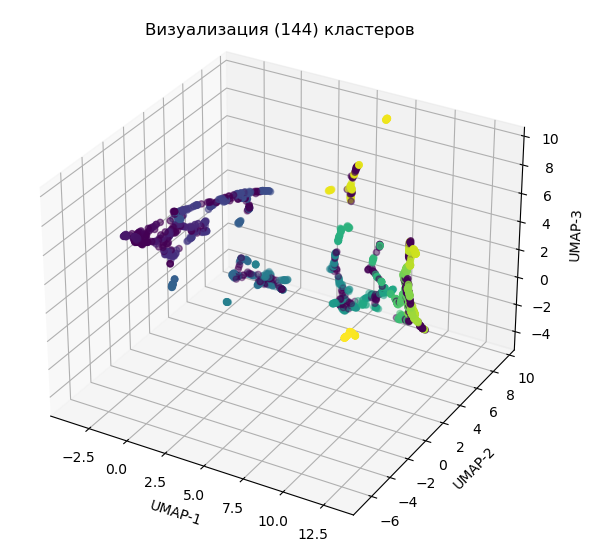

In [30]:
# Визуализация baseline
plot(X_embedding_3, opt_labels)

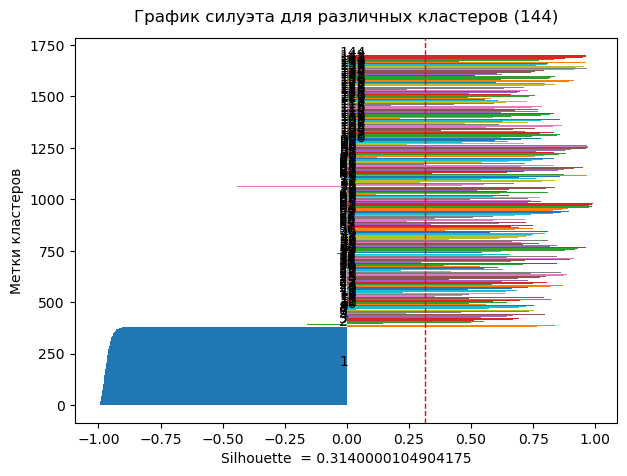

In [31]:
# силуэтный коэффициент 
silhouette_plot(X_embedding_3, opt_labels)

#### Вывод


<div class="alert alert-block alert-info">

OPTICS baseline отработал хуже, чем DBSCAN baseline:
- количество кластеров = 144, что в 5 раза больше чем у DBSCAN (отрицательно влияет на интерпретируемость)
- кластеры более непропорциональны (один кластер перетягивает основную массу объектов)
- силуэтный коэффициент хоть и немного меньше (0.31 vs. 0.35), но для одного кластера показывает гиганскую ошибку


</div>

# Spectral clustering

Достоинства спектральной кластеризации: 
- выявление кластеров сложных форм


Сложности в использовании модели: 
- сложность настройки из-за большого количества гиперпараметров
- необходимо подавать количество кластеров на вход
- высокая вычислительная сложность и потребление памяти за счёт матричных операций

Spectral clustering from Sklearn
- n_clusters=8 - количество кластеров
- eigen_solver=None {‘arpack’, ‘lobpcg’, ‘amg’} - стратегии разложения лаплассиана на собственные вектора и значения
- n_components=None - Количество собственных векторов, используемых для спектрального разложения. Если их нет, по умолчанию используется значение n_clusters
- n_init=10 - Сколько раз алгоритм k-средних будет выполняться с разными начальными значениями центроида.
- gamma=1.0 - коэффициент ядра
- affinity='rbf' - метод построения матрицы сходства
- n_neighbors=10 - Количество соседей для построении матрицы сходства (игнорируется для affinity='rbf)
- eigen_tol='auto'
- assign_labels='kmeans' {‘kmeans’, ‘discretize’, ‘cluster_qr’}
- degree=3, coef0=1 Степень ядра полинома / коэффициент для полиномиальных и сигмовидных ядер

In [32]:
# по умолчанию количество кластеров = 8
sp_clust = SpectralClustering()
sp_clust.fit(X_umap)

SpectralClustering()

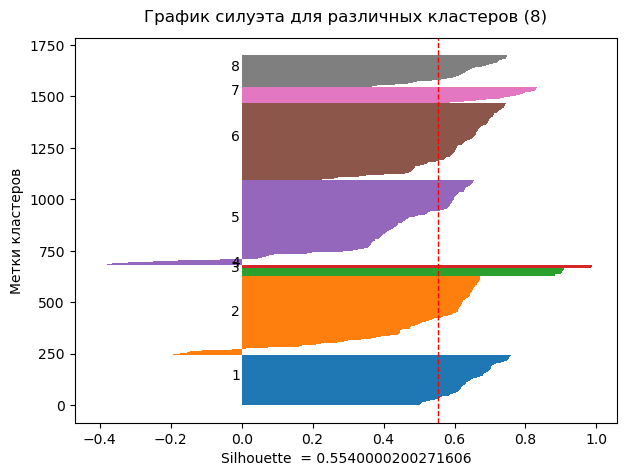

In [33]:
silhouette_plot(X_embedding_3, sp_clust.labels_)

In [34]:
# так как неизвестно сколько кластеров доджно быть, зададим = 28 как в DBSCAN baseline
sp_clust_28 = SpectralClustering(n_clusters=28)
sp_clust_28.fit(X_umap)

SpectralClustering(n_clusters=28)

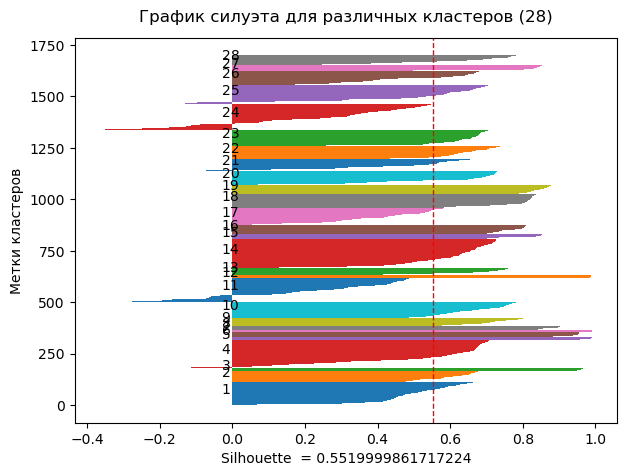

In [35]:
silhouette_plot(X_embedding_3, sp_clust_28.labels_)

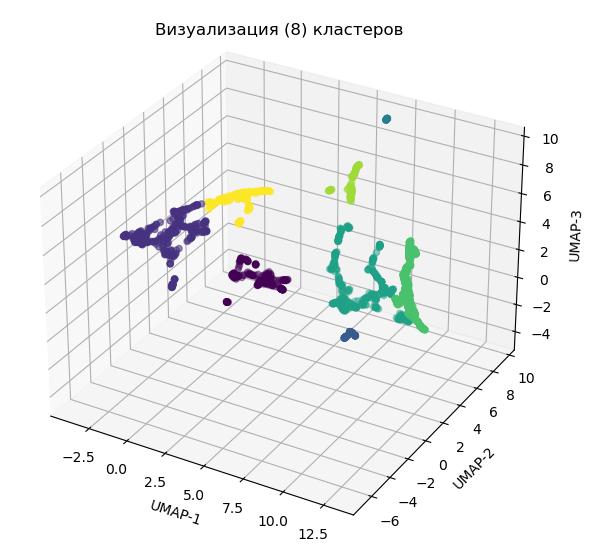

In [36]:
# визуализация 8 кластеров
plot(X_embedding_3, sp_clust.labels_)

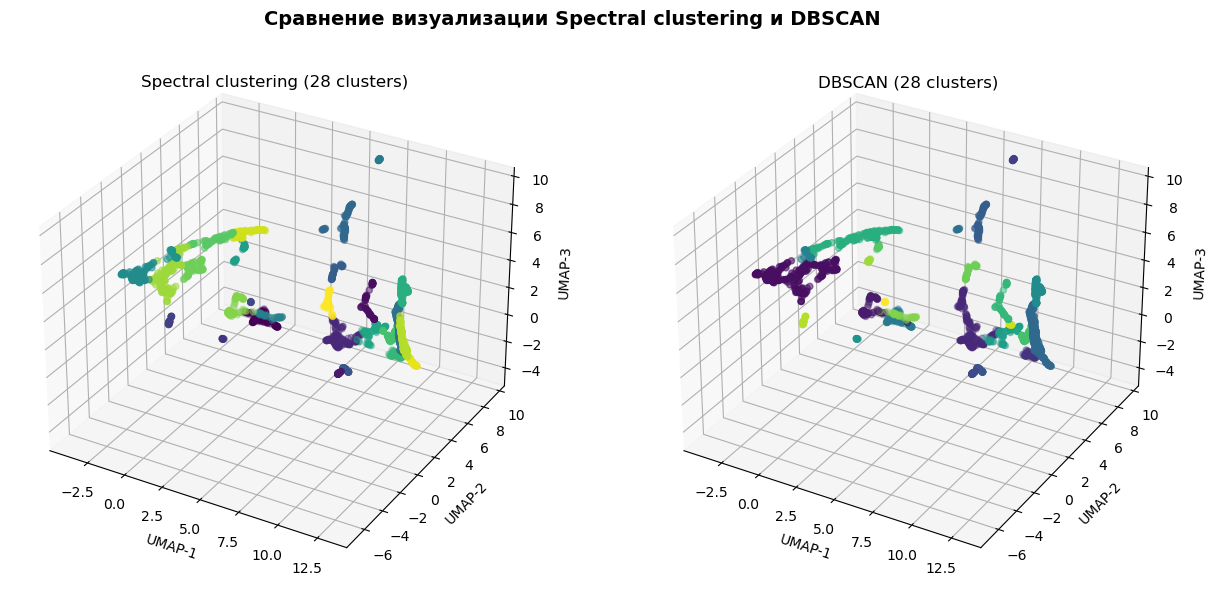

In [37]:
# визуализация 28 кластеров (как в DBSCAN)

fig, ax = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='3d'))

plot(X_embedding_3, sp_clust_28.labels_, ax=ax[0])
plot(X_embedding_3, db_labels_3, ax=ax[1])


ax[0].set_title('Spectral clustering (28 clusters)')
ax[1].set_title('DBSCAN (28 clusters)')

plt.suptitle('Сравнение визуализации Spectral clustering и DBSCAN', 
             fontsize=14, fontweight='semibold', y=0.7)
plt.show()

<div class="alert alert-block alert-info">

Группировки по кластерам для SC и DBSCAN визуально выглядят похоже. Но SC более специфично формирует кластеры: там где в DBSCAN один кластер, для SC два или три. Так как само количество кластеров одинаково, то вероятно это влияет на наполненность кластеров.

</div>

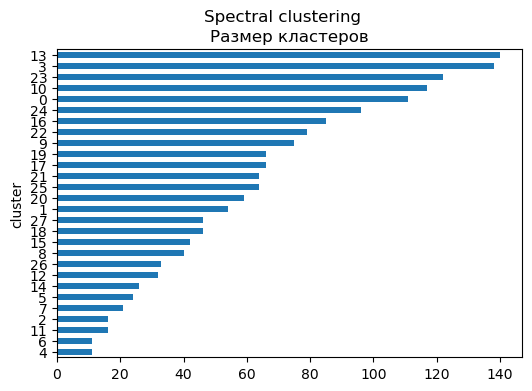

In [54]:
get_size(X_embedding_3, sp_clust_28.labels_)
plt.suptitle('Spectral clustering')

plt.show()

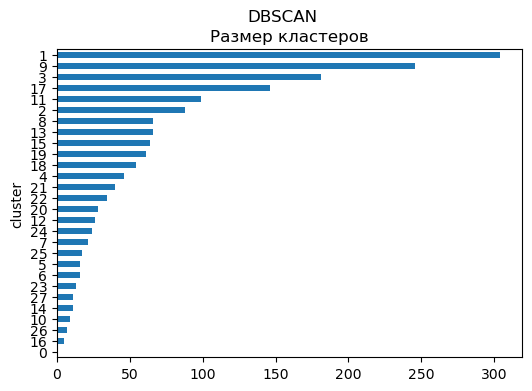

In [52]:
get_size(X_embedding_3, db_labels_3)
plt.suptitle('DBSCAN')

plt.show()

<div class="alert alert-block alert-info">

SC показывает более удачное распределенение наполненности кластеров по сравнению с DBSCAN. В первом случае кластера достаточно равномерны. В то время как для DBSCAN превалирует несколько кластеров, что создаёт существенный дисбаланс при оценке наполнености кластеров в целом. К тому же, максимальный размер кластера для SC = 140, для DBSCAN = 300, что в 2 раза больше. Чем меньше объектов в кластерах, тем удобнее их анализировать в дальнейшем.

</div>

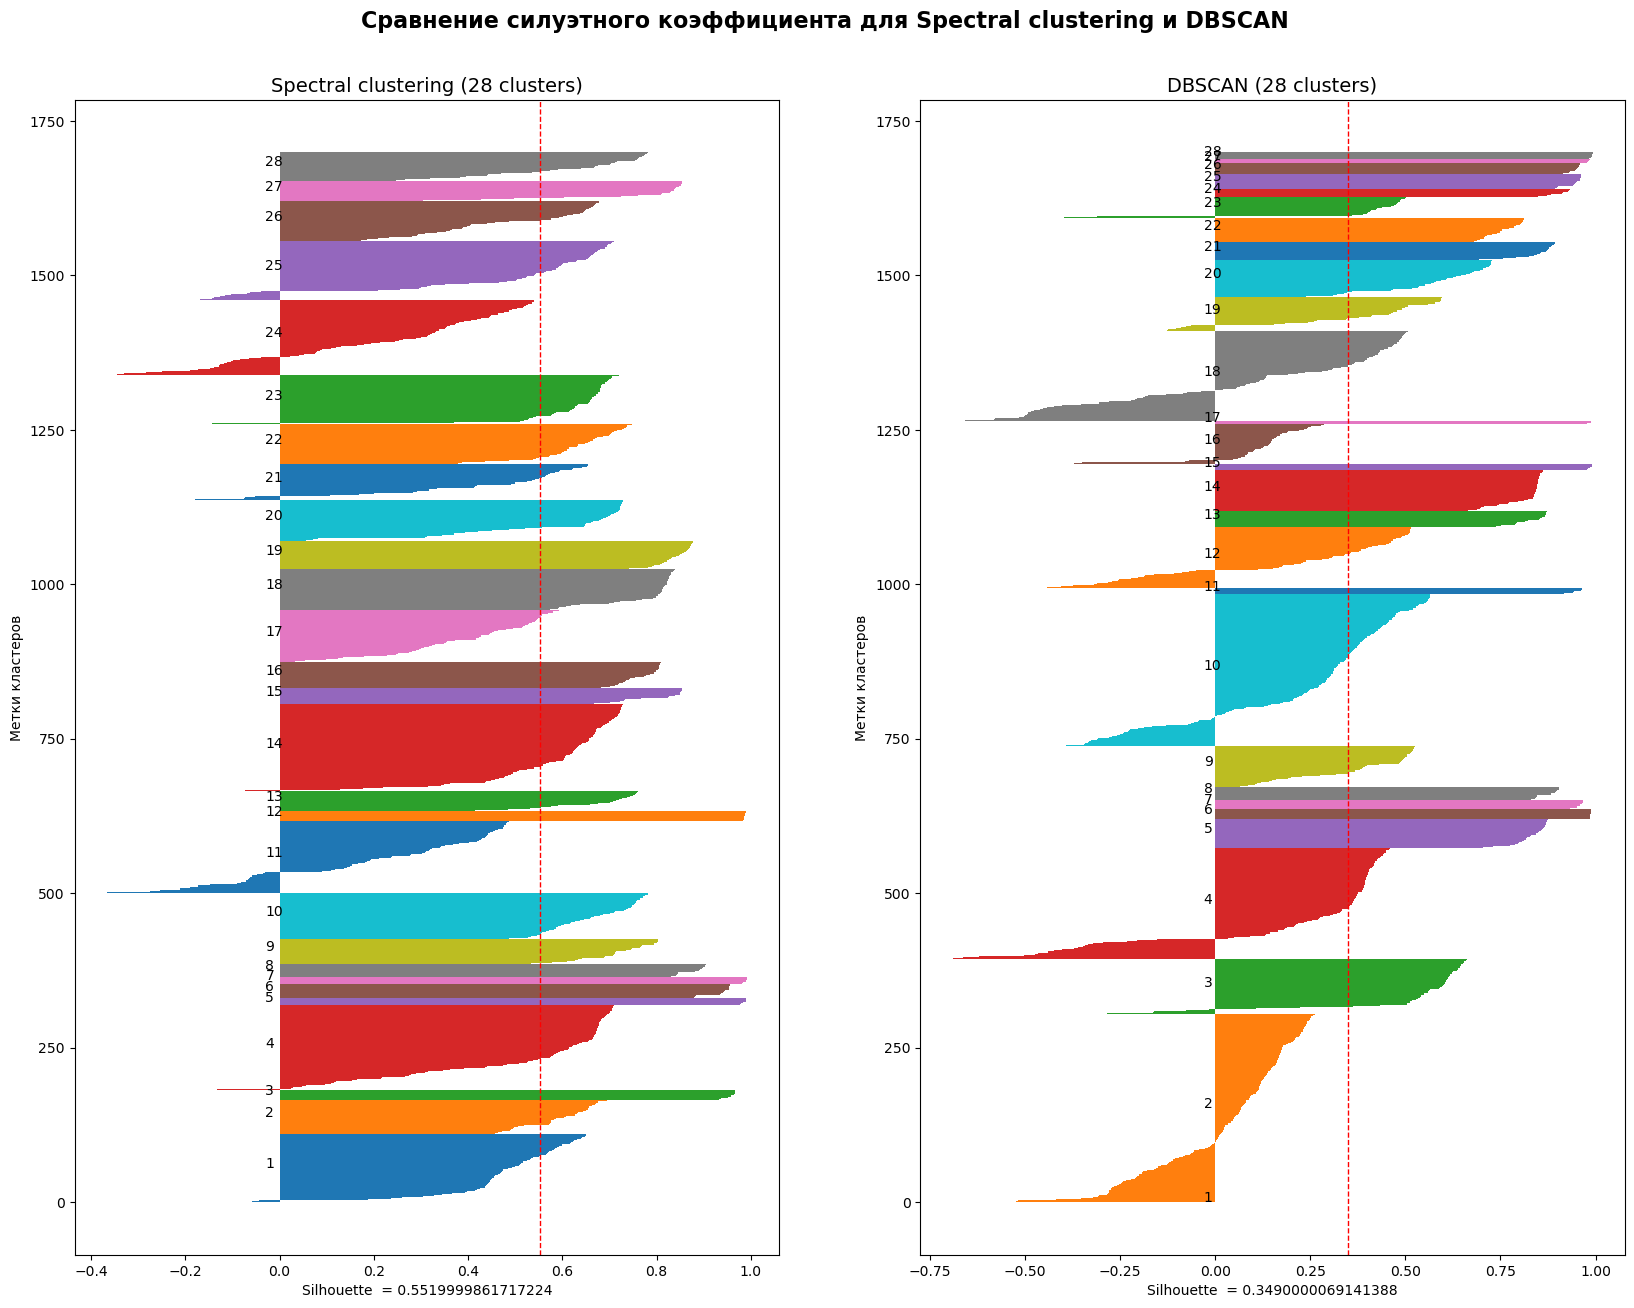

In [60]:
# визуализация 28 кластеров (как в DBSCAN)

fig, ax = plt.subplots(1, 2, figsize=(20, 15))

silhouette_plot(X_embedding_3, sp_clust_28.labels_, ax=ax[0])
silhouette_plot(X_embedding_3, db_labels_3, ax=ax[1])

ax[0].set_title('Spectral clustering (28 clusters)', fontsize=14)
ax[1].set_title('DBSCAN (28 clusters)', fontsize=14)

plt.suptitle('Сравнение силуэтного коэффициента для Spectral clustering и DBSCAN', 
             fontsize=16, fontweight='semibold', y=0.94)
plt.show()

<div class="alert alert-block alert-info">

Средний силуэтный коэффиент для SC больше, чем для DBSCAN (0.55 vs 0.35). Количество кластеров, для которых заметен перекос в отрицательную сторону для SC = 3, для DBSCAN = 6.

</div>

# Выводы по выбору baseline

По результатам сравнения алгоритмов, основанных на преобразованиях через матрицу подобия (spectral clustering) и оценки близости (DBSCAN), лучше себя показал baseline spectral clustering.

Аргументы в поддержку спектральной кластеризации:

- визуально адекватное разбиение на кластеры (для baseline, где кластеров = 8 - идеальное разбиение)
- равномерное распределение элементов по кластерам без явного перекоса
- Средний силуэтный коэффициент > 0.5

В результате, берём за основу спектральную кластеризацию.
На следующем этапе будет подбор гиперпараметров: n_clusters, eigen_solver, affinity. 